---
# 3. Data transformation - 연봉 데이터 다루기
## 3-1. 들어가며
### 학습 내용

    - 데이터 병합, 개요 작성, 결측치 및 이상치 처리, 집계와 피벗 테이블 활용, 로그 변환 및 원-핫 인코딩, 스케일링, 주성분 분석(PCA)을 통해 데이터 변환의 고급 기술을 습득합니다.
    
### 학습 목표
    1. 데이터를 다양한 방법으로 합치고 변환할 수 있다.
    2. 데이터의 스케일을 변환할 수 있다.
    3. 카테고리형 데이터를 숫자형태로 변환할 수 있다.
    4. 데이터의 차원축소를 할 수 있다.  
---

---
## 3-2. Data merge(데이터 병합)
① merge와 join의 특징에 대해 더 알아 봅시다.
- merge: suffix 자동 생성, 동일 이름 컬럼을 구별하기 위해 사용됩니다.
- join: suffix 수동 생성 필요. 컬럼 이름 충돌을 해결합니다.

② pandas에서는 merge 함수를 사용하여 SQL 스타일의 조인을 수행할 수 있습니다.
- Inner join: 공통키 반환 (*merge의 기본 설정)
- Left join: 왼쪽, 모든 행, 오른쪽 일치 행 반환
- Right join: 오른쪽, 모든 행, 왼쪽 일치 행 반환
- Outer join: 두 행을 반환, 불일치 NaN 값으로 채워짐
---

In [1092]:
import pandas as pd
import numpy as np

---
### merge(), join()
---

In [1093]:
df_a = pd.DataFrame({'key':['a','b','c','d','e'], 'num_a':[1,2,3,4,5]})
df_b = pd.DataFrame({'key':['a','b','d','f','g'], 'num_b':[11,15,35,45,55]})
df_c = pd.DataFrame({'key':['f','g','h','i','j'], 'num_a':[6,7,8,9,0]})

In [1094]:
df_a

,key,num_a
0,a,1
1,b,2
2,c,3
3,d,4
4,e,5


In [1095]:
df_b

,key,num_b
0,a,11
1,b,15
2,d,35
3,f,45
4,g,55


In [1096]:
df_c

,key,num_a
0,f,6
1,g,7
2,h,8
3,i,9
4,j,0


In [1097]:
# 위아래로 붙이기 
# 대응되지 않는 값은 null  처리 되면서, 열이 추가로 생성됨 
pd.concat([df_a, df_b])

,key,num_a,num_b
0,a,1.0,NaN
1,b,2.0,NaN
2,c,3.0,NaN
3,d,4.0,NaN
4,e,5.0,NaN
0,a,NaN,11.0
1,b,NaN,15.0
2,d,NaN,35.0
3,f,NaN,45.0
4,g,NaN,55.0


In [1098]:
# 위아래로 붙이기 
# 컬럼명이 같으면 열이 추가로 생성되지 않음 
pd.concat([df_a, df_c])

,key,num_a
0,a,1
1,b,2
2,c,3
3,d,4
4,e,5
0,f,6
1,g,7
2,h,8
3,i,9
4,j,0


In [1099]:
# 위아래로 붙이기 
# 3개도 가능 
pd.concat([df_a, df_b, df_c])

,key,num_a,num_b
0,a,1.0,NaN
1,b,2.0,NaN
2,c,3.0,NaN
3,d,4.0,NaN
4,e,5.0,NaN
0,a,NaN,11.0
1,b,NaN,15.0
2,d,NaN,35.0
3,f,NaN,45.0
4,g,NaN,55.0


In [1100]:
# 가로로 붙이기 
# axis 사용 
pd.concat([df_a, df_b, df_c], axis=1)

,key,num_a,key,num_b,key,num_a
0,a,1,a,11,f,6
1,b,2,b,15,g,7
2,c,3,d,35,h,8
3,d,4,f,45,i,9
4,e,5,g,55,j,0


In [1101]:
# 공통된 키값으로 통합
# concat과 다르게 공통된 키값을 가진 컬럼만 가져옴 (inner join)
# 옆으로 합칠떄 많이씀, 현업에서 자주 씀 
df_a.merge(df_b) 

,key,num_a,num_b
0,a,1,11
1,b,2,15
2,d,4,35


In [1102]:
df_a.merge(df_b, how='inner') # 디폴트가 innerjoin

,key,num_a,num_b
0,a,1,11
1,b,2,15
2,d,4,35


In [1103]:
df_a.merge(df_b, how='outer') 

,key,num_a,num_b
0,a,1.0,11.0
1,b,2.0,15.0
2,c,3.0,NaN
3,d,4.0,35.0
4,e,5.0,NaN
5,f,NaN,45.0
6,g,NaN,55.0


In [1104]:
df_a.merge(df_b, how='left') # key값을 왼쪽 테이블 기준으로 맞춰서 가져옴

,key,num_a,num_b
0,a,1,11.0
1,b,2,15.0
2,c,3,NaN
3,d,4,35.0
4,e,5,NaN


In [1105]:
df_a.merge(df_b, how='right')

,key,num_a,num_b
0,a,1.0,11
1,b,2.0,15
2,d,4.0,35
3,f,NaN,45
4,g,NaN,55


In [1106]:
# 컬럼명을 지정하여 해당 컬럼 기준으로 테이블 가져오기
df_a.merge(df_b, on= 'key', how='right')

,key,num_a,num_b
0,a,1.0,11
1,b,2.0,15
2,d,4.0,35
3,f,NaN,45
4,g,NaN,55


In [1107]:
df_a = pd.DataFrame({'key':['a','b','c','d','e'],'id':['q','w','e','r','t'], 'num_a':[1,2,3,4,5]} )
df_b = pd.DataFrame({'key':['a','b','d','f','g'], 'id':['r','t','e','r','t'], 'num_b':[11,15,35,45,55]})

In [1108]:
df_a

,key,id,num_a
0,a,q,1
1,b,w,2
2,c,e,3
3,d,r,4
4,e,t,5


In [1109]:
df_b

,key,id,num_b
0,a,r,11
1,b,t,15
2,d,e,35
3,f,r,45
4,g,t,55


In [1110]:
df_a.merge(df_b) # 공통 값이 없으므로 매칭 없음 

,key,id,num_a,num_b


In [1111]:
df_a.merge(df_b, on= 'key')

,key,id_x,num_a,id_y,num_b
0,a,q,1,r,11
1,b,w,2,t,15
2,d,r,4,e,35


In [1112]:
df_a.merge(df_b, on= 'id')

,key_x,id,num_a,key_y,num_b
0,c,e,3,d,35
1,d,r,4,a,11
2,d,r,4,f,45
3,e,t,5,b,15
4,e,t,5,g,55


In [1113]:
df_a = pd.DataFrame({'key':['a','b','c','d','e'], 'num_a':[1,2,3,4,5]} )
df_b = pd.DataFrame({'id':['a','b','d','f','g'], 'num_b':[11,15,35,45,55]})

In [1114]:
# 병합방법
# 1. df_b 의 id 컬럼의 이름을 key로 수정하여 맞춰줄 수 있고, 
# 2. left_on, right_on 을 사용할 수 있음 

In [1115]:
df_a.merge(df_b, left_on='key', right_on = 'id', how='outer')

,key,num_a,id,num_b
0,a,1.0,a,11.0
1,b,2.0,b,15.0
2,c,3.0,NaN,NaN
3,d,4.0,d,35.0
4,e,5.0,NaN,NaN
5,NaN,NaN,f,45.0
6,NaN,NaN,g,55.0


In [1116]:
# join으로 병합하기
# join 으로 병합할 태는 동일한 컬럼명이 있으면 에러발생됨
# suffix(별도 컬럼명)을 지정해 줘야 함

In [1117]:
df_a

,key,num_a
0,a,1
1,b,2
2,c,3
3,d,4
4,e,5


In [1118]:
df_b = pd.DataFrame({'key':['a','b','d','f','g'], 'num_b':[11,15,35,45,55]})
df_b

,key,num_b
0,a,11
1,b,15
2,d,35
3,f,45
4,g,55


In [1119]:
df_a.join(df_b, lsuffix='_a', rsuffix='_b')

,key_a,num_a,key_b,num_b
0,a,1,a,11
1,b,2,b,15
2,c,3,d,35
3,d,4,f,45
4,e,5,g,55


In [1120]:
# join의 병합기준은 인덱스에서 잡음
# 그래서 컬럼기준으로 병합하기 위해서는 컬럼을 인덱스로 만들어 줘야 함 
# suffix 안써도 됨 

In [1121]:
df_a = df_a.set_index('key')
df_a

,num_a
key,
a,1
b,2
c,3
d,4
e,5


In [1122]:
df_b = df_b.set_index('key')
df_b

,num_b
key,
a,11
b,15
d,35
f,45
g,55


In [1123]:
df_a.join(df_b)

,num_a,num_b
key,,
a,1,11.0
b,2,15.0
c,3,NaN
d,4,35.0
e,5,NaN


---
### merge(), join()_데이터로 실습
---

In [1124]:
salary_1 = pd.read_csv('/aiffel/data/salary_1.csv')
salary_2 = pd.read_csv('/aiffel/data/salary_2.csv')

In [1125]:
salary_1.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior
0,32.0,Male,1,Software Engineer,5.0,90000,UK,White,0
1,28.0,Female,2,Data Analyst,3.0,65000,USA,Hispanic,0
2,45.0,Male,3,Manager,15.0,150000,Canada,White,1
3,36.0,Female,1,Sales Associate,7.0,60000,USA,Hispanic,0
4,52.0,Male,2,Director,20.0,200000,USA,Asian,0


In [1126]:
salary_2.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior
0,29,Female,1,Human Resources Coordinator,2,45000,China,Chinese,0
1,23,Male,0,Sales Associate,1,25000,USA,Asian,0
2,32,Female,2,Software Developer,7,90000,USA,African American,0
3,44,Male,1,Operations Manager,18,170000,USA,Hispanic,0
4,26,Female,1,Marketing Coordinator,2,40000,Canada,Asian,0


In [1127]:
# concat 을 통해 병합
# concat으로 병합하면 기존 자로의 인덱스값을 그대로 가지고 옴 
# 현재 6684행 자료이지만, 인덱스 마지막 값은 2684
salary_df = pd.concat([salary_1, salary_2])
salary_df 

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior
0,32.0,Male,1,Software Engineer,5.0,90000,UK,White,0
1,28.0,Female,2,Data Analyst,3.0,65000,USA,Hispanic,0
2,45.0,Male,3,Manager,15.0,150000,Canada,White,1
3,36.0,Female,1,Sales Associate,7.0,60000,USA,Hispanic,0
4,52.0,Male,2,Director,20.0,200000,USA,Asian,0
...,...,...,...,...,...,...,...,...,...
2680,49.0,Female,3,Director of Marketing,20.0,200000,UK,Mixed,0
2681,32.0,Male,0,Sales Associate,3.0,50000,Australia,Australian,0
2682,30.0,Female,1,Financial Manager,4.0,55000,China,Chinese,0
2683,46.0,Male,2,Marketing Manager,14.0,140000,China,Korean,0


In [1128]:
# 동일한 인덱스 넘버가 중복
salary_df.loc[0]

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior
0,32.0,Male,1,Software Engineer,5.0,90000,UK,White,0
0,29.0,Female,1,Human Resources Coordinator,2.0,45000,China,Chinese,0


In [1129]:
# 인덱스 초기화 
salary_df.reset_index()

,index,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior
0,0,32.0,Male,1,Software Engineer,5.0,90000,UK,White,0
1,1,28.0,Female,2,Data Analyst,3.0,65000,USA,Hispanic,0
2,2,45.0,Male,3,Manager,15.0,150000,Canada,White,1
3,3,36.0,Female,1,Sales Associate,7.0,60000,USA,Hispanic,0
4,4,52.0,Male,2,Director,20.0,200000,USA,Asian,0
...,...,...,...,...,...,...,...,...,...,...
6679,2680,49.0,Female,3,Director of Marketing,20.0,200000,UK,Mixed,0
6680,2681,32.0,Male,0,Sales Associate,3.0,50000,Australia,Australian,0
6681,2682,30.0,Female,1,Financial Manager,4.0,55000,China,Chinese,0
6682,2683,46.0,Male,2,Marketing Manager,14.0,140000,China,Korean,0


In [1130]:
salary_df = salary_df.reset_index(drop = True) # (drop = True) 뒤에 inplace = True를 써도 덮어쓰기 됨
salary_df

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior
0,32.0,Male,1,Software Engineer,5.0,90000,UK,White,0
1,28.0,Female,2,Data Analyst,3.0,65000,USA,Hispanic,0
2,45.0,Male,3,Manager,15.0,150000,Canada,White,1
3,36.0,Female,1,Sales Associate,7.0,60000,USA,Hispanic,0
4,52.0,Male,2,Director,20.0,200000,USA,Asian,0
...,...,...,...,...,...,...,...,...,...
6679,49.0,Female,3,Director of Marketing,20.0,200000,UK,Mixed,0
6680,32.0,Male,0,Sales Associate,3.0,50000,Australia,Australian,0
6681,30.0,Female,1,Financial Manager,4.0,55000,China,Chinese,0
6682,46.0,Male,2,Marketing Manager,14.0,140000,China,Korean,0


In [1131]:
# cpi = 연봉 분석을 위해, 국가별 소비자 물가지수(cpi) 로 가져옴 
cpi = pd.read_csv('/aiffel/data/cpi.csv')
cpi.head()

,Country,Reference,Last,Previous,Units,Frequency
0,United States,Sep-23,307.48,306.27,"Index 1982-84=100, SA",Monthly
1,China,Sep-23,100,100.1,"Index CPPY=100, NSA",Monthly
2,Germany,Sep-23,117.9,117.5,"Index 2020=100, CDASA",Monthly
3,France,Sep-23,118.52,118.2,"Index 2015=100, SA",Monthly
4,United Kingdom,Sep-23,132,131.3,"Index 2015=100, NSA",Monthly


In [1132]:
# 데이터별 국가명 확인
salary_df['Country'].unique

<bound method Series.unique of 0              UK
1             USA
2          Canada
3             USA
4             USA
          ...    
6679           UK
6680    Australia
6681        China
6682        China
6683       Canada
Name: Country, Length: 6684, dtype: object>

In [1133]:
# salary_df 기준으로 병합해야 하므로 United States, United Kingdom 를 USA, UK로 통일
cpi['Country'].unique()

array(['United States', 'China', 'Germany', 'France', 'United Kingdom',
       'Brazil', 'Italy', 'Russian Federation', 'Canada', 'Australia',
       'Spain', 'South Korea', 'Mexico', 'Indonesia', 'Netherlands'],
      dtype=object)

In [1134]:
cpi['Country'] = cpi['Country'].replace({'United Kingdom':'UK', 'United States':'USA'})
cpi

,Country,Reference,Last,Previous,Units,Frequency
0,USA,Sep-23,307.48,306.27,"Index 1982-84=100, SA",Monthly
1,China,Sep-23,100,100.1,"Index CPPY=100, NSA",Monthly
2,Germany,Sep-23,117.9,117.5,"Index 2020=100, CDASA",Monthly
3,France,Sep-23,118.52,118.2,"Index 2015=100, SA",Monthly
4,UK,Sep-23,132,131.3,"Index 2015=100, NSA",Monthly
5,Brazil,Sep-23,"6,700","6,683","Index Dec1993=100, NSA",Monthly
6,Italy,Aug-23,120.1,119.7,"Index 2015=100, NSA",Monthly
7,Russian Federation,Nov-21,205.5,203.5,"Index 2010=100, NSA",Monthly
8,Canada,Sep-23,158.7,158.4,"Index 2002=100, SA",Monthly
9,Australia,2023 Q3,135.3,133.7,"Index FY 2012=100, NSA",Quarterly


In [1135]:
salary_df = salary_df.merge(cpi, on='Country', how='left')

In [1136]:
salary_df.drop(['Reference','Previous','Units','Frequency'], axis=1, inplace=True)

In [1137]:
salary_df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior,Last
0,32.0,Male,1,Software Engineer,5.0,90000,UK,White,0,132
1,28.0,Female,2,Data Analyst,3.0,65000,USA,Hispanic,0,307.48
2,45.0,Male,3,Manager,15.0,150000,Canada,White,1,158.7
3,36.0,Female,1,Sales Associate,7.0,60000,USA,Hispanic,0,307.48
4,52.0,Male,2,Director,20.0,200000,USA,Asian,0,307.48


In [1138]:
salary_df = salary_df.rename({'Last' : 'cpi'}, axis = 1)
salary_df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior,cpi
0,32.0,Male,1,Software Engineer,5.0,90000,UK,White,0,132
1,28.0,Female,2,Data Analyst,3.0,65000,USA,Hispanic,0,307.48
2,45.0,Male,3,Manager,15.0,150000,Canada,White,1,158.7
3,36.0,Female,1,Sales Associate,7.0,60000,USA,Hispanic,0,307.48
4,52.0,Male,2,Director,20.0,200000,USA,Asian,0,307.48


---
## 3-3. 개요, 결측치&이상치, 집계 및 그룹화, 피벗테이블

① Overview : 데이터의 기본 특성 파악, 구조와 내용을 이해하는 데 도움을 줍니다. 
- head( ): 데이터프레임의 처음 몇 행(기본적으로 5행)을 표시
- tail( ): 데이터프레임의 마지막 몇 행을 표시
- describe( ): 수치형 열에 대한 기술통계를 제공
- info( ): 데이터프레임의 기본 정보를 제공
- dtypes: 각 열의 데이터 타입을 보여줌

② Outlier : 이상치(Outlier)를 탐지하고 처리하는 데 사용되는 여러 방법과 함수들이 있습니다.
- 통계적 방법: Z-점수와 IQR을 사용하여 이상치를 식별
- 시각적 방법: 박스 플롯으로 이상치를 시각화하여 이상치를 식별
- 데이터 필터링: 조건에 따라 이상치 필터링 및 제거등의 방법으로 이상치를 식별

③ Aggregation : 여러 데이터 포인트를 요약, 그룹화하여 통계 또는 정보를 추출
- groupby( ): 데이터를 특정 기준으로 그룹화하여 집계 연산에 적용
- 집계 함수:  각 그룹의 요약 통계를 제공 합니다.
    - sum( ), mean( ), median( ), min( ), max( ), count( )
- std( ) 함수 : 표준편차, 값들이 평균으로부터 얼마나 멀리 퍼져 있는지를 측정
- agg( ) 함수: 다양한 집계 함수를 한 번에 적용하여 다양한 요약 통계를 얻을 수 있음

④ Pivot Table
- 데이터프레임을 재구 특정 열을 새로운 행과 열의 인덱스로 사용하고, 다른 열의 데이터로 새로운 표를 만드는 데 사용됩니다.
---

In [1139]:
# 데이터 파악 
# cpi                  6684 non-null   object  -> 데이터 타입 확인 필요 (원래는 숫자 형태데이터)
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6684 entries, 0 to 6683
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6680 non-null   float64
 1   Gender               6684 non-null   object 
 2   Education Level      6684 non-null   int64  
 3   Job Title            6684 non-null   object 
 4   Years of Experience  6684 non-null   float64
 5   Salary               6684 non-null   int64  
 6   Country              6684 non-null   object 
 7   Race                 6684 non-null   object 
 8   Senior               6684 non-null   int64  
 9   cpi                  6684 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 574.4+ KB


In [1140]:
# cpi 컬럼을 숫자로 변환 
salary_df['cpi'] = pd.to_numeric(salary_df['cpi'])

In [1141]:
salary_df.describe()

,Age,Education Level,Years of Experience,Salary,Senior,cpi
count,6680.000000,6684.000000,6684.000000,6684.000000,6684.000000,6684.00000
mean,33.611527,1.622382,8.084007,115307.175194,0.143477,167.12953
std,7.595506,0.880474,6.097824,52806.810881,0.350585,73.22657
min,21.000000,0.000000,-1.000000,350.000000,0.000000,100.00000
25%,28.000000,1.000000,3.000000,70000.000000,0.000000,132.00000
50%,32.000000,1.000000,7.000000,115000.000000,0.000000,135.30000
75%,38.000000,2.000000,12.000000,160000.000000,0.000000,158.70000
max,62.000000,3.000000,82.000000,250000.000000,1.000000,307.48000


---
### 결측치 처리
---

In [1142]:
# 결측치 확인
salary_df.isna().sum()

Age                    4
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
Country                0
Race                   0
Senior                 0
cpi                    0
dtype: int64

In [1143]:
salary_df.isna().mean()

Age                    0.000598
Gender                 0.000000
Education Level        0.000000
Job Title              0.000000
Years of Experience    0.000000
Salary                 0.000000
Country                0.000000
Race                   0.000000
Senior                 0.000000
cpi                    0.000000
dtype: float64

In [1144]:
salary_df[salary_df['Age'].isna()]

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior,cpi
548,NaN,Male,1,Data Analyst,3.0,130000,Canada,White,0,158.70
2135,NaN,Female,3,Project Engineer,16.0,190000,USA,African American,1,307.48
2749,NaN,Female,1,Software Engineer,1.0,50000,Australia,White,0,135.30
3826,NaN,Female,2,Marketing Coordinator,8.0,85000,UK,Asian,0,132.00


In [1145]:
#결측치 제거 
salary_df = salary_df.dropna()

---
### 이상치 처리
---

In [1146]:
# 이상치 확인
salary_df[salary_df['Years of Experience'] == -1]

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior,cpi
102,49.0,Female,2,HR Manager,-1.0,150000,Australia,White,1,135.3
256,35.0,Male,1,Project Coordinator,-1.0,95000,UK,Asian,1,132.0
359,34.0,Male,1,Operations Coordinator,-1.0,90000,China,Chinese,1,100.0


In [1147]:
# 이상치 제거
salary_df = salary_df[salary_df['Years of Experience'] != -1]

In [1148]:
# 이상치 확인
salary_df['Years of Experience'].sort_values()

4931     0.0
5104     0.0
5115     0.0
5119     0.0
5143     0.0
        ... 
2396    33.0
2391    33.0
2490    34.0
2415    34.0
564     82.0
Name: Years of Experience, Length: 6677, dtype: float64

In [1149]:
salary_df[salary_df['Years of Experience'] == 82]

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior,cpi
564,25.0,Female,1,Data Analyst,82.0,110000,Australia,White,0,135.3


In [1150]:
# 이상치 확인을 위해, Age 와 Years of Experience 컬럼을 비교 
salary_df[salary_df['Years of Experience'] > salary_df['Age']]

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior,cpi
564,25.0,Female,1,Data Analyst,82.0,110000,Australia,White,0,135.3


In [1151]:
# 이상치 확인을 위해, Age 와 Years of Experience 컬럼을 비교 
salary_df[salary_df['Years of Experience'] > salary_df['Age'] -18]

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior,cpi
564,25.0,Female,1,Data Analyst,82.0,110000,Australia,White,0,135.3
2373,25.0,Male,3,Software Engineer Manager,12.0,169159,China,Chinese,0,100.0
2448,25.0,Male,3,Software Engineer Manager,12.0,169159,China,White,0,100.0


In [1152]:
# 이상치 제거 (조금이라도 의심스러운 데이터가 있으면 일단 제외)
# 이상치 확인을 위해, Age 와 Years of Experience 컬럼을 비교 
salary_df = salary_df[salary_df['Years of Experience'] <= salary_df['Age'] -18]

In [1153]:
# 경력 0이 보임, 확인필요
salary_df.describe()

,Age,Education Level,Years of Experience,Salary,Senior,cpi
count,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000
mean,33.612826,1.622116,8.076491,115294.402307,0.143093,167.164774
std,7.594369,0.880460,6.029750,52819.326323,0.350193,73.241730
min,21.000000,0.000000,0.000000,350.000000,0.000000,100.000000
25%,28.000000,1.000000,3.000000,70000.000000,0.000000,132.000000
50%,32.000000,1.000000,7.000000,115000.000000,0.000000,135.300000
75%,38.000000,2.000000,12.000000,160000.000000,0.000000,158.700000
max,62.000000,3.000000,34.000000,250000.000000,1.000000,307.480000


In [1154]:
# 꽤많이 보임, 경력 1년이하인 것으로 판단할 수 있음 
salary_df[salary_df['Years of Experience'] == 0]

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior,cpi
18,25.0,Female,1,Data Entry Clerk,0.0,35000,UK,Asian,0,132.00
49,25.0,Male,1,Help Desk Analyst,0.0,35000,USA,Asian,0,307.48
82,25.0,Male,1,Sales Representative,0.0,30000,Australia,Asian,0,135.30
2416,24.0,Male,2,Back end Developer,0.0,55538,USA,Asian,0,307.48
2430,22.0,Female,0,Back end Developer,0.0,51832,UK,White,0,132.00
...,...,...,...,...,...,...,...,...,...,...
6179,24.0,Female,0,Receptionist,0.0,25000,China,White,0,100.00
6193,24.0,Female,0,Receptionist,0.0,25000,Australia,Australian,0,135.30
6207,24.0,Female,0,Receptionist,0.0,25000,Australia,White,0,135.30
6221,24.0,Female,0,Receptionist,0.0,25000,UK,Welsh,0,132.00


---
### Group by()
---

In [1155]:
salary_df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior,cpi
0,32.0,Male,1,Software Engineer,5.0,90000,UK,White,0,132.00
1,28.0,Female,2,Data Analyst,3.0,65000,USA,Hispanic,0,307.48
2,45.0,Male,3,Manager,15.0,150000,Canada,White,1,158.70
3,36.0,Female,1,Sales Associate,7.0,60000,USA,Hispanic,0,307.48
4,52.0,Male,2,Director,20.0,200000,USA,Asian,0,307.48


In [1156]:
# 성별 평균 Salary 계산 (Group by 없이)
salary_df[salary_df['Gender'] =='Female']['Salary'].mean()

107873.85405585106

In [1157]:
# Group by 함수 사용 
salary_df.groupby('Gender').mean()

,Age,Education Level,Years of Experience,Salary,Senior,cpi
Gender,,,,,,
Female,32.622008,1.600066,7.417221,107873.854056,0.127992,167.485166
Male,34.425805,1.640207,8.617430,121383.057283,0.155483,166.901888


In [1158]:
salary_df.groupby('Gender').max()

,Age,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior,cpi
Gender,,,,,,,,,
Female,60.0,3,Web Developer,34.0,220000,USA,White,1,307.48
Male,62.0,3,Web Developer,32.0,250000,USA,White,1,307.48


In [1159]:
salary_df.groupby('Gender')['Salary'].mean()

Gender
Female    107873.854056
Male      121383.057283
Name: Salary, dtype: float64

In [1160]:
salary_df.groupby('Gender')['Salary'].sum()

Gender
Female    324484553
Male      444990288
Name: Salary, dtype: int64

In [1161]:
salary_df.groupby('Gender')['Salary'].median()

Gender
Female    105000.0
Male      120000.0
Name: Salary, dtype: float64

In [1162]:
salary_df.groupby(['Gender', 'Country'])['Salary'].median() # 판다스 시리즈 출력

Gender  Country  
Female  Australia    110000.0
        Canada       105000.0
        China        110000.0
        UK           105000.0
        USA          100000.0
Male    Australia    120000.0
        Canada       130000.0
        China        120000.0
        UK           120000.0
        USA          120000.0
Name: Salary, dtype: float64

In [1163]:
 # 판다스 시리즈 출력, 인덱스 수정으로 epdlxj 데이터 프레임으로 편집가능 유용함★
salary_df.groupby(['Gender', 'Country'])['Salary'].median().reset_index()

,Gender,Country,Salary
0,Female,Australia,110000.0
1,Female,Canada,105000.0
2,Female,China,110000.0
3,Female,UK,105000.0
4,Female,USA,100000.0
5,Male,Australia,120000.0
6,Male,Canada,130000.0
7,Male,China,120000.0
8,Male,UK,120000.0
9,Male,USA,120000.0


In [1164]:
salary_df.groupby(['Gender'])['Salary'].agg(['sum','min'])

,sum,min
Gender,,
Female,324484553,500
Male,444990288,350


---
### Pivot_table()
---

In [1165]:
# 피벗테이블 생성시 평균값 계산이 디폴트, aggfunc 으로 수정
pd.pivot_table(salary_df, index='Gender', columns='Country', values = 'Salary')

Country,Australia,Canada,China,UK,USA
Gender,,,,,
Female,107936.054010,106884.711340,111291.211506,108495.273026,104854.691558
Male,120896.764216,123973.921516,120135.522148,122244.048476,119683.120433


In [1166]:
pd.pivot_table(salary_df, index='Gender', columns='Country', values = 'Salary', aggfunc='sum')

Country,Australia,Canada,China,UK,USA
Gender,,,,,
Female,65948929,62206902,65773106,65965126,64590490
Male,87166567,91616728,89500964,88260203,88445826


In [1167]:
pd.pivot_table(salary_df, index='Gender', columns='Country', values = 'Salary', aggfunc=np.mean)

Country,Australia,Canada,China,UK,USA
Gender,,,,,
Female,107936.054010,106884.711340,111291.211506,108495.273026,104854.691558
Male,120896.764216,123973.921516,120135.522148,122244.048476,119683.120433


In [1168]:
pd.pivot_table(salary_df, index=['Gender','Race'], columns='Country', values = 'Salary', aggfunc=np.mean)

Country                      Australia         Canada          China  \
Gender Race                                                            
Female African American            NaN            NaN            NaN   
       Asian             107715.561905  105812.939394            NaN   
       Australian        108245.014354            NaN            NaN   
       Black                       NaN  108602.208333            NaN   
       Chinese                     NaN            NaN  106422.709184   
       Hispanic                    NaN            NaN            NaN   
       Korean                      NaN            NaN  110948.144186   
       Mixed                       NaN            NaN            NaN   
       Welsh                       NaN            NaN            NaN   
       White             107840.901042  106272.479167  117002.244444   
Male   African American            NaN            NaN            NaN   
       Asian             119691.533835  122360.988327            NaN   
       Australian        119390.000000            NaN            NaN   
       Black                       NaN  126169.440329            NaN   
       Chinese                     NaN            NaN  114959.159184   
       Hispanic                    NaN            NaN            NaN   
       Korean                      NaN            NaN  122565.033058   
       Mixed                       NaN            NaN            NaN   
       Welsh                       NaN            NaN            NaN   
       White             124136.080189  123476.066946  122772.217054   

Country                             UK            USA  
Gender Race                                            
Female African American            NaN  102991.926667  
       Asian             106991.835714  104991.940120  
       Australian                  NaN            NaN  
       Black                       NaN            NaN  
       Chinese                     NaN            NaN  
       Hispanic                    NaN  104509.158273  
       Korean                      NaN            NaN  
       Mixed             108091.310345            NaN  
       Welsh             108379.775758            NaN  
       White             110318.772152  106757.962500  
Male   African American            NaN  118956.572139  
       Asian             127269.465969  121556.553571  
       Australian                  NaN            NaN  
       Black                       NaN            NaN  
       Chinese                     NaN            NaN  
       Hispanic                    NaN  114892.306011  
       Korean                      NaN            NaN  
       Mixed             122652.206349            NaN  
       Welsh             116666.857143            NaN  
       White             121669.172414  123469.315508

In [1169]:
#[추가] pivot 함수는 pivot_table 과 달리 연산을 수행하지 않고 데이터를 뿌려주기만 함 

In [1170]:
sales_df = pd.DataFrame({'company':['a','a','a','a','b','b','b','b'],
             'quarter':['q1', 'q2', 'q3', 'q4', 'q1', 'q2', 'q3', 'q4'],
             'sales':['111','222', '333','444','555', '666', '777', '888']})

In [1171]:
sales_df

,company,quarter,sales
0,a,q1,111
1,a,q2,222
2,a,q3,333
3,a,q4,444
4,b,q1,555
5,b,q2,666
6,b,q3,777
7,b,q4,888


In [1172]:
sales_temp = pd.pivot(slaes_df, index='company', columns='quarter', values='sales')

In [1173]:
sales_temp

quarter,q1,q2,q3,q4
company,,,,
a,111,222,333,444
b,555,666,777,888


In [1174]:
sales_temp.columns

Index(['q1', 'q2', 'q3', 'q4'], dtype='object', name='quarter')

In [1175]:
sales_temp.columns = sales_temp.columns.rename('')

In [1176]:
sales_temp

,q1,q2,q3,q4
company,,,,
a,111,222,333,444
b,555,666,777,888


In [1177]:
sales_temp.columns

Index(['q1', 'q2', 'q3', 'q4'], dtype='object', name='')

In [1178]:
sales_temp

,q1,q2,q3,q4
company,,,,
a,111,222,333,444
b,555,666,777,888


In [1179]:
sales_temp.reset_index()

,company,q1,q2,q3,q4
0,a,111,222,333,444
1,b,555,666,777,888


In [1180]:
new_sales_df = sales_temp.reset_index()

In [1181]:
new_sales_df

,company,q1,q2,q3,q4
0,a,111,222,333,444
1,b,555,666,777,888


In [1182]:
#pd.pivot 디폴트가 평균이라 변화 없음 (값이 하나 뿐임 )
pd.pivot_table(sales_df, index='company', columns='quarter', values='sales')

quarter,q1,q2,q3,q4
company,,,,
a,111.0,222.0,333.0,444.0
b,555.0,666.0,777.0,888.0


---
### ★pd.melt()★
---

In [1183]:
# pd.melt -> 피봇 테이블을 원래 데이터 프레임 형태로 만드는 함수
# id_vars - 처음 기준컬럼값 
# value_vars - id_vars 에 할당하여 녹여낼 컬럼들 모두 입력
pd.melt(new_sales_df, id_vars='company', value_vars=['q1','q2','q3','q4'], value_name='sales')


,company,,sales
0,a,q1,111
1,b,q1,555
2,a,q2,222
3,b,q2,666
4,a,q3,333
5,b,q3,777
6,a,q4,444
7,b,q4,888


In [1184]:
pd.melt(new_sales_df, id_vars='company', value_vars=['q1','q2','q3','q4'], var_name='quarter', value_name='sales')

,company,quarter,sales
0,a,q1,111
1,b,q1,555
2,a,q2,222
3,b,q2,666
4,a,q3,333
5,b,q3,777
6,a,q4,444
7,b,q4,888


---
## 3-4. 로그(Log), 원-핫 인코딩 (One hot encoding)
① Log Transformation
- 데이터의 변환을 위해 로그 함수를 적용하는 과정
- 데이터의 스케일을 조정하거나 정규성을 높이는 데 사용됩니다.

② get_dummies
- 주어진 범주형 열의 각 고유 범주를 대표하는 새로운 이진(0 또는 1) 열을 생성합니다.
___

---
### np.log()
---

In [1185]:
price_df=pd.DataFrame({'level':[1,2,3,4,5,6,7,], 
             'price':[1,10,100,1000,10000,100000,1000000]})

<AxesSubplot:xlabel='level', ylabel='price'>

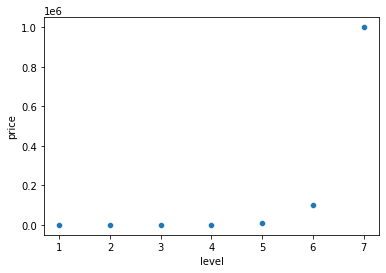

In [1186]:
import seaborn as sns
sns.scatterplot(x=price_df['level'], y=price_df['price'])

<AxesSubplot:xlabel='level', ylabel='price'>

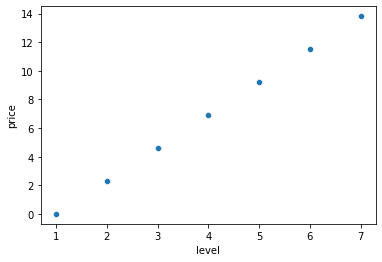

In [1187]:
sns.scatterplot(x=price_df['level'], y=np.log(price_df['price']))

In [1188]:
# np.log() 반대 함수는 np.exp()

---
### 원-핫 인코딩 (One hot encoding)
--- 

In [1189]:
# 머신러닝 모델링 하기 위해서는 문자 데이터를 숫자로 변환 필요 
# 단, 숫자 변환 시 0,1(True, False)로 매핑해야함 (2,3 등의 숫자는 쓰지 못함)
# 세부 이론 설명은 LMS 참조

In [1190]:
# Gender 컬럼을 원핫 인코딩 
pd.get_dummies(salary_df, columns=['Gender'])

,Age,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior,cpi,Gender_Female,Gender_Male
0,32.0,1,Software Engineer,5.0,90000,UK,White,0,132.00,0,1
1,28.0,2,Data Analyst,3.0,65000,USA,Hispanic,0,307.48,1,0
2,45.0,3,Manager,15.0,150000,Canada,White,1,158.70,0,1
3,36.0,1,Sales Associate,7.0,60000,USA,Hispanic,0,307.48,1,0
4,52.0,2,Director,20.0,200000,USA,Asian,0,307.48,0,1
...,...,...,...,...,...,...,...,...,...,...,...
6679,49.0,3,Director of Marketing,20.0,200000,UK,Mixed,0,132.00,1,0
6680,32.0,0,Sales Associate,3.0,50000,Australia,Australian,0,135.30,0,1
6681,30.0,1,Financial Manager,4.0,55000,China,Chinese,0,100.00,1,0
6682,46.0,2,Marketing Manager,14.0,140000,China,Korean,0,100.00,0,1


In [1191]:
# Gender 컬럼중 첫번째 값 drop - 원핫 인코딩시 컬럼이 늘어나므로 컬럼수 줄이고 연산 부담 최초화 
pd.get_dummies(salary_df, columns=['Gender'], drop_first = True)

,Age,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior,cpi,Gender_Male
0,32.0,1,Software Engineer,5.0,90000,UK,White,0,132.00,1
1,28.0,2,Data Analyst,3.0,65000,USA,Hispanic,0,307.48,0
2,45.0,3,Manager,15.0,150000,Canada,White,1,158.70,1
3,36.0,1,Sales Associate,7.0,60000,USA,Hispanic,0,307.48,0
4,52.0,2,Director,20.0,200000,USA,Asian,0,307.48,1
...,...,...,...,...,...,...,...,...,...,...
6679,49.0,3,Director of Marketing,20.0,200000,UK,Mixed,0,132.00,0
6680,32.0,0,Sales Associate,3.0,50000,Australia,Australian,0,135.30,1
6681,30.0,1,Financial Manager,4.0,55000,China,Chinese,0,100.00,0
6682,46.0,2,Marketing Manager,14.0,140000,China,Korean,0,100.00,1


In [1192]:
# 컬럼 생략없이 보기 or 필요한 만큼 보기 
pd.set_option('display.max_columns', 50)

In [1193]:
# 컬럼의 고유값이 많으면 원핫 인코딩시 새로 생성되는 컬럼이 많아짐 
pd.get_dummies(salary_df, columns=['Gender', 'Country', 'Race'], drop_first = True)

,Age,Education Level,Job Title,Years of Experience,Salary,Senior,cpi,Gender_Male,Country_Canada,Country_China,Country_UK,Country_USA,Race_Asian,Race_Australian,Race_Black,Race_Chinese,Race_Hispanic,Race_Korean,Race_Mixed,Race_Welsh,Race_White
0,32.0,1,Software Engineer,5.0,90000,0,132.00,1,0,0,1,0,0,0,0,0,0,0,0,0,1
1,28.0,2,Data Analyst,3.0,65000,0,307.48,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,45.0,3,Manager,15.0,150000,1,158.70,1,1,0,0,0,0,0,0,0,0,0,0,0,1
3,36.0,1,Sales Associate,7.0,60000,0,307.48,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,52.0,2,Director,20.0,200000,0,307.48,1,0,0,0,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6679,49.0,3,Director of Marketing,20.0,200000,0,132.00,0,0,0,1,0,0,0,0,0,0,0,1,0,0
6680,32.0,0,Sales Associate,3.0,50000,0,135.30,1,0,0,0,0,0,1,0,0,0,0,0,0,0
6681,30.0,1,Financial Manager,4.0,55000,0,100.00,0,0,1,0,0,0,0,0,1,0,0,0,0,0
6682,46.0,2,Marketing Manager,14.0,140000,0,100.00,1,0,1,0,0,0,0,0,0,0,1,0,0,0


In [1194]:
salary_df[['Gender','Country','Race', 'Job Title']].nunique()

Gender         2
Country        5
Race          10
Job Title    129
dtype: int64

In [1195]:
salary_df['Job Title'].value_counts()

Software Engineer                 808
Data Scientist                    515
Data Analyst                      389
Software Engineer Manager         374
Product Manager                   323
                                 ... 
Director of Sales                   1
UX Researcher                       1
Director of Product Management      1
Consultant                          1
Human Resources Director            1
Name: Job Title, Length: 129, dtype: int64

In [1196]:
# 실제로 데이터의 종류를 확인하고, 같은 내용이 다른 텍스트로 중복 작성되지않았는지 검토 필요 
# 데이터 검토하여 고유값의 숫자를 최소화 할 필요 있음 
# 큰 덩어리로 묶어서 정리해야 할듯
salary_df['Job Title'].unique()

array(['Software Engineer', 'Data Analyst', 'Manager', 'Sales Associate',
       'Director', 'Marketing Analyst', 'Product Manager',
       'Sales Manager', 'Marketing Coordinator', 'Scientist',
       'Software Developer', 'HR Manager', 'Financial Analyst',
       'Project Manager', 'Customer Service Rep', 'Operations Manager',
       'Marketing Manager', 'Engineer', 'Data Entry Clerk',
       'Sales Director', 'Business Analyst', 'VP of Operations',
       'IT Support', 'Recruiter', 'Financial Manager',
       'Social Media Specialist', 'Software Manager', 'Developer',
       'Consultant', 'Product Designer', 'CEO', 'Accountant',
       'Data Scientist', 'Marketing Specialist', 'Technical Writer',
       'HR Generalist', 'Project Engineer', 'Customer Success Rep',
       'Sales Executive', 'UX Designer', 'Operations Director',
       'Network Engineer', 'Administrative Assistant',
       'Strategy Consultant', 'Copywriter', 'Account Manager',
       'Director of Marketing', 'Help Des

In [1197]:
# Job Title 정리파일
job = pd.read_csv('/aiffel/data/job.csv')

In [1198]:
job

,Job Title,Jobs
0,Software Engineer,Software
1,Data Analyst,Data Analyst
2,Manager,Manager
3,Sales Associate,Sales
4,Director,Director
...,...,...
123,Juniour HR Coordinator,HR
124,Digital Marketing Specialist,Marketing
125,Receptionist,Receptionist
126,Social Media Man,Social Media


In [1199]:
salary_df.merge(job, on ='Job Title', how = 'left')

,Age,Gender,Education Level,Job Title,Years of Experience,Salary,Country,Race,Senior,cpi,Jobs
0,32.0,Male,1,Software Engineer,5.0,90000,UK,White,0,132.00,Software
1,28.0,Female,2,Data Analyst,3.0,65000,USA,Hispanic,0,307.48,Data Analyst
2,45.0,Male,3,Manager,15.0,150000,Canada,White,1,158.70,Manager
3,36.0,Female,1,Sales Associate,7.0,60000,USA,Hispanic,0,307.48,Sales
4,52.0,Male,2,Director,20.0,200000,USA,Asian,0,307.48,Director
...,...,...,...,...,...,...,...,...,...,...,...
6669,49.0,Female,3,Director of Marketing,20.0,200000,UK,Mixed,0,132.00,Marketing
6670,32.0,Male,0,Sales Associate,3.0,50000,Australia,Australian,0,135.30,Sales
6671,30.0,Female,1,Financial Manager,4.0,55000,China,Chinese,0,100.00,Financial
6672,46.0,Male,2,Marketing Manager,14.0,140000,China,Korean,0,100.00,Marketing


In [1200]:
# Job Title 정리파일 적용하고 기존 컬럼 제거 
salary_df = salary_df.merge(job, on ='Job Title', how = 'left')

In [1201]:
salary_df.drop('Job Title', axis=1, inplace=True)

In [1202]:
salary_df.head()

,Age,Gender,Education Level,Years of Experience,Salary,Country,Race,Senior,cpi,Jobs
0,32.0,Male,1,5.0,90000,UK,White,0,132.00,Software
1,28.0,Female,2,3.0,65000,USA,Hispanic,0,307.48,Data Analyst
2,45.0,Male,3,15.0,150000,Canada,White,1,158.70,Manager
3,36.0,Female,1,7.0,60000,USA,Hispanic,0,307.48,Sales
4,52.0,Male,2,20.0,200000,USA,Asian,0,307.48,Director


In [1203]:
salary_df.nunique()

Age                     41
Gender                   2
Education Level          4
Years of Experience     37
Salary                 436
Country                  5
Race                    10
Senior                   2
cpi                      5
Jobs                    60
dtype: int64

In [1204]:
# 1건짜리 데이터는 others 로 묶는 방법도 있음 
salary_df['Jobs'].value_counts()

Software                        2156
Marketing                        999
Data Scientist                   572
Sales                            453
HR                               420
Data Analyst                     389
Product Manager                  325
Project Engineer                 316
Financial                        200
Research                         195
Operations                       147
Web Developer                    129
Product Designer                  80
Receptionist                      57
Project Manager                   36
Business Analyst                  23
Graphic Designer                  23
Social Media                      18
Customer Service                  11
Business Development               7
UX                                 6
Accountant                         6
Business Development Manager       5
Account                            5
Delivery Driver                    5
Project Coordinator                4
Scientist                          4
R

In [1205]:
salary_df = pd.get_dummies(salary_df, columns = ['Gender','Country', 'Race','Jobs'], drop_first=True)

In [1206]:
salary_df

,Age,Education Level,Years of Experience,Salary,Senior,cpi,Gender_Male,Country_Canada,Country_China,Country_UK,Country_USA,Race_Asian,Race_Australian,Race_Black,Race_Chinese,Race_Hispanic,Race_Korean,Race_Mixed,Race_Welsh,Race_White,Jobs_Accountant,Jobs_Administrative,Jobs_Advertising Coordinator,Jobs_Business Analyst,Jobs_Business Development,...,Jobs_Network Engineer,Jobs_Office Manager,Jobs_Operations,Jobs_PR,Jobs_Product Designer,Jobs_Product Manager,Jobs_Project Coordinator,Jobs_Project Engineer,Jobs_Project Manager,Jobs_Quality Assurance,Jobs_Receptionist,Jobs_Recruiter,Jobs_Research,Jobs_Sales,Jobs_Scientist,Jobs_Social Media,Jobs_Software,Jobs_Supply Chain,Jobs_Supply Chain Manager,Jobs_Technical Support Specialist,Jobs_Technical Writer,Jobs_Training Specialist,Jobs_UX,Jobs_Web Designer,Jobs_Web Developer
0,32.0,1,5.0,90000,0,132.00,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,28.0,2,3.0,65000,0,307.48,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,45.0,3,15.0,150000,1,158.70,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,36.0,1,7.0,60000,0,307.48,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,52.0,2,20.0,200000,0,307.48,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6669,49.0,3,20.0,200000,0,132.00,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6670,32.0,0,3.0,50000,0,135.30,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6671,30.0,1,4.0,55000,0,100.00,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6672,46.0,2,14.0,140000,0,100.00,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


---
## 3-5. 스케일링 (Scaling)
① Scaling 

- 데이터의 범위를 조정하는 과정. 특성의 스케일을 조정 합니다.

- 거리기반 모델(KNN 등)을 쓸때는 반드시 스케일링 써서 각각 변수의 특성에 따라 동일한 스케일을 지닐수 있게 맞춰주는것이 중요 합니다.

② 주요 Scaling 방법 :

- Standardization : 각 데이터 포인트에서 평균을 빼고, 그 결과를 표준편차로 나누어 줍니다. 결과적으로 데이터는 평균이 0이고 표준편차가 1인 분포를 갖게 됩니다.
- Robust Scaling : 이 방법은 중앙값과 사분위 범위를 사용하여 데이터를 스케일링합니다. 표준화와 유사하지만, 이상치의 영향을 덜 받습니다.
- MinMaxScaler : 데이터를 0과 1 사이의 범위로 조정합니다. 주로 최소값과 최대값을 사용하여 계산합니다. 주로 MinMaxScaler라는 클래스를 통해 구현됩니다.

③ 각 Scaling 방법의 적합한 상황과 특징:

- **Standardization :** 아웃라이어가 없는 경우, 변수의 분포가 정규분포를 따를 때 적합합니다.
    - 리니어 리그레이션(연속적인 값 예측), 로지스틱 회귀(분류 문제에 적합한 확률 결과 제공), 서포트 벡터 머신(이진 또는 다중 클래스 분류, 회귀)에 사용됩니다.
    - 주의사항 : 아웃라이어에 민감하므로, 아웃라이어가 존재하지 않을 때 더 효과적입니다.
- **Robust Scaling :** 아웃라이어가 많은 데이터에 적합 합니다.
    - 특징 : 정규분포를 따르지 않는 데이터에 적용하기 좋은 방법입니다.
- **MinMaxScaler :** 데이터의 범위를 0에서 1로 제한하고자 할 때 적합 합니다.
    - 주로 딥러닝 모델에서 사용됩니다.
    - 특징 : 스케일링 범위를 제한하고자 할 때 유용합니다.
---

In [1207]:
# 함수없이 계산

In [1208]:
salary_df.head()

,Age,Education Level,Years of Experience,Salary,Senior,cpi,Gender_Male,Country_Canada,Country_China,Country_UK,Country_USA,Race_Asian,Race_Australian,Race_Black,Race_Chinese,Race_Hispanic,Race_Korean,Race_Mixed,Race_Welsh,Race_White,Jobs_Accountant,Jobs_Administrative,Jobs_Advertising Coordinator,Jobs_Business Analyst,Jobs_Business Development,...,Jobs_Network Engineer,Jobs_Office Manager,Jobs_Operations,Jobs_PR,Jobs_Product Designer,Jobs_Product Manager,Jobs_Project Coordinator,Jobs_Project Engineer,Jobs_Project Manager,Jobs_Quality Assurance,Jobs_Receptionist,Jobs_Recruiter,Jobs_Research,Jobs_Sales,Jobs_Scientist,Jobs_Social Media,Jobs_Software,Jobs_Supply Chain,Jobs_Supply Chain Manager,Jobs_Technical Support Specialist,Jobs_Technical Writer,Jobs_Training Specialist,Jobs_UX,Jobs_Web Designer,Jobs_Web Developer
0,32.0,1,5.0,90000,0,132.00,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,28.0,2,3.0,65000,0,307.48,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,45.0,3,15.0,150000,1,158.70,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,36.0,1,7.0,60000,0,307.48,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,52.0,2,20.0,200000,0,307.48,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1209]:
# Standard Scaling -함수없이 공식에 따라 계산

In [1210]:
salary_df['Age'].mean()

33.61282589151933

In [1211]:
salary_df['Age'].std()

7.594369005848066

In [1212]:
(salary_df['Age'] - salary_df['Age'].mean())/salary_df['Age'].std()

0      -0.212371
1      -0.739077
2       1.499423
3       0.314335
4       2.421159
          ...   
6669    2.026129
6670   -0.212371
6671   -0.475724
6672    1.631100
6673   -1.002430
Name: Age, Length: 6674, dtype: float64

In [1213]:
# Robust Scaling 계산법 - 공식에 따라 코드 구성 (사분위값 사용)

In [1214]:
(salary_df['Age'] - salary_df['Age'].quantile(0.5))/(salary_df['Age'].quantile(0.75)-salary_df['Age'].quantile(0.25))

0       0.0
1      -0.4
2       1.3
3       0.4
4       2.0
       ... 
6669    1.7
6670    0.0
6671   -0.2
6672    1.4
6673   -0.6
Name: Age, Length: 6674, dtype: float64

In [1215]:
# MinMaxScaling 계산법 - 공식에 따라 코드 구성 (사분위값 사용)

In [1216]:
(salary_df['Age'] - salary_df['Age'].min())/(salary_df['Age'].max()-salary_df['Age'].min())

0       0.268293
1       0.170732
2       0.585366
3       0.365854
4       0.756098
          ...   
6669    0.682927
6670    0.268293
6671    0.219512
6672    0.609756
6673    0.121951
Name: Age, Length: 6674, dtype: float64

In [1217]:
#sklearn 함수 사용 
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [1218]:
# 함수별로 별칭 지정 
ss = StandardScaler()
rs = RobustScaler()
mm = MinMaxScaler()

In [1219]:
# ss 로 salary_df를 학습
ss.fit(salary_df)

StandardScaler()

In [1220]:
# 학습한 내용으로 데이터를 분석
# 넘파이 어레이 형태로 출력해서 보기가 어려움 
ss.transform(salary_df)

array([[-0.2123872 , -0.70663318, -0.51025684, ..., -0.029997  ,
        -0.01224164, -0.14039125],
       [-0.7391327 ,  0.42922179, -0.84197037, ..., -0.029997  ,
        -0.01224164, -0.14039125],
       [ 1.49953568,  1.56507675,  1.14831086, ..., -0.029997  ,
        -0.01224164, -0.14039125],
       ...,
       [-0.47575995, -0.70663318, -0.6761136 , ..., -0.029997  ,
        -0.01224164, -0.14039125],
       [ 1.63122206,  0.42922179,  0.98245409, ..., -0.029997  ,
        -0.01224164, -0.14039125],
       [-1.00250545, -1.84248814, -1.17368391, ..., -0.029997  ,
        -0.01224164, -0.14039125]])

In [1221]:
# 넘파이 어레이를 데이터 프레임으로 수정
# 그냥하면 컬럼명이 안들어 오므로 columns = salary_df.columns 추가
pd.DataFrame(ss.transform(salary_df), columns = salary_df.columns)

,Age,Education Level,Years of Experience,Salary,Senior,cpi,Gender_Male,Country_Canada,Country_China,Country_UK,Country_USA,Race_Asian,Race_Australian,Race_Black,Race_Chinese,Race_Hispanic,Race_Korean,Race_Mixed,Race_Welsh,Race_White,Jobs_Accountant,Jobs_Administrative,Jobs_Advertising Coordinator,Jobs_Business Analyst,Jobs_Business Development,...,Jobs_Network Engineer,Jobs_Office Manager,Jobs_Operations,Jobs_PR,Jobs_Product Designer,Jobs_Product Manager,Jobs_Project Coordinator,Jobs_Project Engineer,Jobs_Project Manager,Jobs_Quality Assurance,Jobs_Receptionist,Jobs_Recruiter,Jobs_Research,Jobs_Sales,Jobs_Scientist,Jobs_Social Media,Jobs_Software,Jobs_Supply Chain,Jobs_Supply Chain Manager,Jobs_Technical Support Specialist,Jobs_Technical Writer,Jobs_Training Specialist,Jobs_UX,Jobs_Web Designer,Jobs_Web Developer
0,-0.212387,-0.706633,-0.510257,-0.478921,-0.408641,-0.480155,0.905822,-0.496767,-0.500281,2.004506,-0.504725,-0.560853,-0.269528,-0.264051,-0.265993,-0.225150,-0.271124,-0.229524,-0.229162,1.555332,-0.029997,-0.017314,-0.012242,-0.058806,-0.012242,...,-0.012242,-0.012242,-0.150073,-0.012242,-0.110146,-0.22625,-0.024489,-0.222938,-0.073643,-0.012242,-0.092813,-0.024489,-0.173486,-0.269848,-0.024489,-0.052003,1.447601,-0.012242,-0.012242,-0.021206,-0.012242,-0.017314,-0.029997,-0.012242,-0.140391
1,-0.739133,0.429222,-0.841970,-0.952268,-0.408641,1.915926,-1.103970,-0.496767,-0.500281,-0.498876,1.981278,-0.560853,-0.269528,-0.264051,-0.265993,4.441476,-0.271124,-0.229524,-0.229162,-0.642950,-0.029997,-0.017314,-0.012242,-0.058806,-0.012242,...,-0.012242,-0.012242,-0.150073,-0.012242,-0.110146,-0.22625,-0.024489,-0.222938,-0.073643,-0.012242,-0.092813,-0.024489,-0.173486,-0.269848,-0.024489,-0.052003,-0.690798,-0.012242,-0.012242,-0.021206,-0.012242,-0.017314,-0.029997,-0.012242,-0.140391
2,1.499536,1.565077,1.148311,0.657112,2.447137,-0.115582,0.905822,2.013016,-0.500281,-0.498876,-0.504725,-0.560853,-0.269528,-0.264051,-0.265993,-0.225150,-0.271124,-0.229524,-0.229162,1.555332,-0.029997,-0.017314,-0.012242,-0.058806,-0.012242,...,-0.012242,-0.012242,-0.150073,-0.012242,-0.110146,-0.22625,-0.024489,-0.222938,-0.073643,-0.012242,-0.092813,-0.024489,-0.173486,-0.269848,-0.024489,-0.052003,-0.690798,-0.012242,-0.012242,-0.021206,-0.012242,-0.017314,-0.029997,-0.012242,-0.140391
3,0.314358,-0.706633,-0.178543,-1.046938,-0.408641,1.915926,-1.103970,-0.496767,-0.500281,-0.498876,1.981278,-0.560853,-0.269528,-0.264051,-0.265993,4.441476,-0.271124,-0.229524,-0.229162,-0.642950,-0.029997,-0.017314,-0.012242,-0.058806,-0.012242,...,-0.012242,-0.012242,-0.150073,-0.012242,-0.110146,-0.22625,-0.024489,-0.222938,-0.073643,-0.012242,-0.092813,-0.024489,-0.173486,3.705792,-0.024489,-0.052003,-0.690798,-0.012242,-0.012242,-0.021206,-0.012242,-0.017314,-0.029997,-0.012242,-0.140391
4,2.421340,0.429222,1.977595,1.603806,-0.408641,1.915926,0.905822,-0.496767,-0.500281,-0.498876,1.981278,1.782999,-0.269528,-0.264051,-0.265993,-0.225150,-0.271124,-0.229524,-0.229162,-0.642950,-0.029997,-0.017314,-0.012242,-0.058806,-0.012242,...,-0.012242,-0.012242,-0.150073,-0.012242,-0.110146,-0.22625,-0.024489,-0.222938,-0.073643,-0.012242,-0.092813,-0.024489,-0.173486,-0.269848,-0.024489,-0.052003,-0.690798,-0.012242,-0.012242,-0.021206,-0.012242,-0.017314,-0.029997,-0.012242,-0.140391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6669,2.026281,1.565077,1.977595,1.603806,-0.408641,-0.480155,-1.103970,-0.496767,-0.500281,2.004506,-0.504725,-0.560853,-0.269528,-0.264051,-0.265993,-0.225150,-0.271124,4.356838,-0.229162,-0.642950,-0.029997,-0.017314,-0.012242,-0.058806,-0.012242,...,-0.012242,-0.012242,-0.150073,-0.012242,-0.110146,-0.22625,-0.024489,-0.222938,-0.073643,-0.012242,-0.092813,-0.024489,-0.173486,-0.269848,-0.024489,-0.052003,-0.690798,-0.012242,-0.012242,-0.021206,-0.012242,-0.017314

In [1222]:
ss_df = pd.DataFrame(ss.transform(salary_df), columns = salary_df.columns)

In [1223]:
rs.fit(salary_df)

RobustScaler()

In [1224]:
rs.transform(salary_df)

array([[ 0.        ,  0.        , -0.22222222, ...,  0.        ,
         0.        ,  0.        ],
       [-0.4       ,  1.        , -0.44444444, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.3       ,  2.        ,  0.88888889, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.2       ,  0.        , -0.33333333, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.4       ,  1.        ,  0.77777778, ...,  0.        ,
         0.        ,  0.        ],
       [-0.6       , -1.        , -0.66666667, ...,  0.        ,
         0.        ,  0.        ]])

In [1225]:
pd.DataFrame(rs.transform(salary_df), columns = salary_df.columns)

,Age,Education Level,Years of Experience,Salary,Senior,cpi,Gender_Male,Country_Canada,Country_China,Country_UK,Country_USA,Race_Asian,Race_Australian,Race_Black,Race_Chinese,Race_Hispanic,Race_Korean,Race_Mixed,Race_Welsh,Race_White,Jobs_Accountant,Jobs_Administrative,Jobs_Advertising Coordinator,Jobs_Business Analyst,Jobs_Business Development,...,Jobs_Network Engineer,Jobs_Office Manager,Jobs_Operations,Jobs_PR,Jobs_Product Designer,Jobs_Product Manager,Jobs_Project Coordinator,Jobs_Project Engineer,Jobs_Project Manager,Jobs_Quality Assurance,Jobs_Receptionist,Jobs_Recruiter,Jobs_Research,Jobs_Sales,Jobs_Scientist,Jobs_Social Media,Jobs_Software,Jobs_Supply Chain,Jobs_Supply Chain Manager,Jobs_Technical Support Specialist,Jobs_Technical Writer,Jobs_Training Specialist,Jobs_UX,Jobs_Web Designer,Jobs_Web Developer
0,0.0,0.0,-0.222222,-0.277778,0.0,-0.123596,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.4,1.0,-0.444444,-0.555556,0.0,6.448689,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.3,2.0,0.888889,0.388889,1.0,0.876404,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.4,0.0,0.000000,-0.611111,0.0,6.448689,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,1.0,1.444444,0.944444,0.0,6.448689,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6669,1.7,2.0,1.444444,0.944444,0.0,-0.123596,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6670,0.0,-1.0,-0.444444,-0.722222,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6671,-0.2,0.0,-0.333333,-0.666667,0.0,-1.322097,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6672,1.4,1.0,0.777778,0.277778,0.0,-1.322097,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1226]:
rs_df = pd.DataFrame(rs.transform(salary_df), columns = salary_df.columns)

In [1227]:
mm.fit(salary_df)

MinMaxScaler()

In [1228]:
mm.transform(salary_df)

array([[0.26829268, 0.33333333, 0.14705882, ..., 0.        , 0.        ,
        0.        ],
       [0.17073171, 0.66666667, 0.08823529, ..., 0.        , 0.        ,
        0.        ],
       [0.58536585, 1.        , 0.44117647, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.2195122 , 0.33333333, 0.11764706, ..., 0.        , 0.        ,
        0.        ],
       [0.6097561 , 0.66666667, 0.41176471, ..., 0.        , 0.        ,
        0.        ],
       [0.12195122, 0.        , 0.02941176, ..., 0.        , 0.        ,
        0.        ]])

In [1229]:
pd.DataFrame(mm.transform(salary_df), columns = salary_df.columns)

,Age,Education Level,Years of Experience,Salary,Senior,cpi,Gender_Male,Country_Canada,Country_China,Country_UK,Country_USA,Race_Asian,Race_Australian,Race_Black,Race_Chinese,Race_Hispanic,Race_Korean,Race_Mixed,Race_Welsh,Race_White,Jobs_Accountant,Jobs_Administrative,Jobs_Advertising Coordinator,Jobs_Business Analyst,Jobs_Business Development,...,Jobs_Network Engineer,Jobs_Office Manager,Jobs_Operations,Jobs_PR,Jobs_Product Designer,Jobs_Product Manager,Jobs_Project Coordinator,Jobs_Project Engineer,Jobs_Project Manager,Jobs_Quality Assurance,Jobs_Receptionist,Jobs_Recruiter,Jobs_Research,Jobs_Sales,Jobs_Scientist,Jobs_Social Media,Jobs_Software,Jobs_Supply Chain,Jobs_Supply Chain Manager,Jobs_Technical Support Specialist,Jobs_Technical Writer,Jobs_Training Specialist,Jobs_UX,Jobs_Web Designer,Jobs_Web Developer
0,0.268293,0.333333,0.147059,0.359103,0.0,0.154232,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.170732,0.666667,0.088235,0.258963,0.0,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.585366,1.000000,0.441176,0.599439,1.0,0.282919,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.365854,0.333333,0.205882,0.238935,0.0,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.756098,0.666667,0.588235,0.799720,0.0,1.000000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6669,0.682927,1.000000,0.588235,0.799720,0.0,0.154232,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6670,0.268293,0.000000,0.088235,0.198878,0.0,0.170137,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6671,0.219512,0.333333,0.117647,0.218906,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6672,0.609756,0.666667,0.411765,0.559383,0.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1230]:
mm_df = pd.DataFrame(mm.transform(salary_df), columns = salary_df.columns)

In [1231]:
ss_df.describe()

,Age,Education Level,Years of Experience,Salary,Senior,cpi,Gender_Male,Country_Canada,Country_China,Country_UK,Country_USA,Race_Asian,Race_Australian,Race_Black,Race_Chinese,Race_Hispanic,Race_Korean,Race_Mixed,Race_Welsh,Race_White,Jobs_Accountant,Jobs_Administrative,Jobs_Advertising Coordinator,Jobs_Business Analyst,Jobs_Business Development,...,Jobs_Network Engineer,Jobs_Office Manager,Jobs_Operations,Jobs_PR,Jobs_Product Designer,Jobs_Product Manager,Jobs_Project Coordinator,Jobs_Project Engineer,Jobs_Project Manager,Jobs_Quality Assurance,Jobs_Receptionist,Jobs_Recruiter,Jobs_Research,Jobs_Sales,Jobs_Scientist,Jobs_Social Media,Jobs_Software,Jobs_Supply Chain,Jobs_Supply Chain Manager,Jobs_Technical Support Specialist,Jobs_Technical Writer,Jobs_Training Specialist,Jobs_UX,Jobs_Web Designer,Jobs_Web Developer
count,6.674000e+03,6.674000e+03,6674.000000,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,...,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6674.000000,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03,6.674000e+03
mean,3.406858e-17,1.277572e-16,0.000000,1.022057e-16,1.022057e-16,-2.571113e-16,-1.192400e-16,-7.186340e-17,-3.619786e-17,-6.427782e-17,-2.235750e-17,-4.152108e-17,3.460090e-17,3.832715e-17,-6.387858e-18,4.870742e-17,5.323215e-18,-3.327009e-17,3.193929e-17,4.471501e-17,-4.258572e-18,2.129286e-18,-1.064643e-18,-2.981000e-17,-1.064643e-18,...,-2.129286e-18,-2.129286e-18,-2.555143e-17,-1.064643e-18,-3.406858e-17,2.555143e-17,-8.517144e-18,6.813715e-17,3.406858e-17,-1.064643e-18,-1.703429e-17,-1.064643e-17,0.000000,3.406858e-17,-1.064643e-17,3.406858e-17,-3.406858e-17,-2.129286e-18,-1.064643e-18,4.258572e-18,-2.129286e-18,-2.129286e-18,-4.258572e-18,-2.129286e-18,-4.258572e-17
std,1.000075e+00,1.000075e+00,1.000075,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,...,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00,1.000075e+00
min,-1.660937e+00,-1.842488e+00,-1.339541,-2.176344e+00,-4.086407e-01,-9.170975e-01,-1.103970e+00,-4.967671e-01,-5.002809e-01,-4.988760e-01,-5.047248e-01,-5.608528e-01,-2.695282e-01,-2.640506e-01,-2.659933e-01,-2.251504e-01,-2.711238e-01,-2.295243e-01,-2.291623e-01,-6.429496e-01,-2.999700e-02,-1.731358e-02,-1.224164e-02,-5.880584e-02,-1.224164e-02,...,-1.224164e-02,-1.224164e-02,-1.500728e-01,-1.224164e-02,-1.101465e-01,-2.262502e-01,-2.448878e-02,-2.229376e-01,-7.364320e-02,-1.224164e-02,-9.281258e-02,-2.448878e-02,-0.173486,-2.698479e-01,-2.448878e-02,-5.200314e-02,-6.907983e-01,-1.224164e-02,-1.224164e-02,-2.120631e-02,-1.224164e-02,-1.731358e-02,-2.999700e-02,-1.224164e-02,-1.403912e-01
25%,-7.391327e-01,-7.066332e-01,-0.841970,-8.575989e-01,-4.086407e-01,-4.801554e-01,-1.103970e+00,-4.967671e-01,-5.002809e-01,-4.988760e-01,-5.047248e-01,-5.608528e-01,-2.695282e-01,-2.640506e-01,-2.659933e-01,-2.251504e-01,-2.711238e-01,-2.295243e-01,-2.291623e-01,-6.429496e-01,-2.999700e-02,-1.731358e-02,-1.224164e-02,-5.880584e-02,-1.224164e-02,...,-1.224164e-02,-1.224164e-02,-1.500728e-01,-1.224164e-02,-1.101465e-01,-2.262502e-01,-2.448878e-02,-2.229376e-01,-7.364320e-02,-1.22

In [1232]:
rs_df.describe()

,Age,Education Level,Years of Experience,Salary,Senior,cpi,Gender_Male,Country_Canada,Country_China,Country_UK,Country_USA,Race_Asian,Race_Australian,Race_Black,Race_Chinese,Race_Hispanic,Race_Korean,Race_Mixed,Race_Welsh,Race_White,Jobs_Accountant,Jobs_Administrative,Jobs_Advertising Coordinator,Jobs_Business Analyst,Jobs_Business Development,...,Jobs_Network Engineer,Jobs_Office Manager,Jobs_Operations,Jobs_PR,Jobs_Product Designer,Jobs_Product Manager,Jobs_Project Coordinator,Jobs_Project Engineer,Jobs_Project Manager,Jobs_Quality Assurance,Jobs_Receptionist,Jobs_Recruiter,Jobs_Research,Jobs_Sales,Jobs_Scientist,Jobs_Social Media,Jobs_Software,Jobs_Supply Chain,Jobs_Supply Chain Manager,Jobs_Technical Support Specialist,Jobs_Technical Writer,Jobs_Training Specialist,Jobs_UX,Jobs_Web Designer,Jobs_Web Developer
count,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.00000,6674.000000,6674.000000,6674.000000,...,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.00000,6674.000000,6674.000000,6674.000000
mean,0.161283,0.622116,0.119610,0.003271,0.143093,1.193437,-0.450704,0.197932,0.200180,0.199281,0.203027,0.239287,0.067726,0.065178,0.066077,0.048247,0.068475,0.050045,0.049895,0.292478,0.000899,0.00030,0.000150,0.003446,0.000150,...,0.000150,0.000150,0.022026,0.000150,0.011987,0.048696,0.000599,0.047348,0.005394,0.000150,0.008541,0.000599,0.029218,0.067875,0.000599,0.002697,0.323045,0.000150,0.000150,0.000450,0.000150,0.00030,0.000899,0.000150,0.019329
std,0.759437,0.880460,0.669972,0.586881,0.350193,2.743136,0.497601,0.398471,0.400165,0.399490,0.402282,0.426680,0.251293,0.246859,0.248436,0.214304,0.252578,0.218054,0.217745,0.454935,0.029972,0.01731,0.012241,0.058608,0.012241,...,0.012241,0.012241,0.146778,0.012241,0.108834,0.215249,0.024476,0.212398,0.073251,0.012241,0.092027,0.024476,0.168429,0.251551,0.024476,0.051867,0.467675,0.012241,0.012241,0.021198,0.012241,0.01731,0.029972,0.012241,0.137688
min,-1.100000,-1.000000,-0.777778,-1.273889,0.000000,-1.322097,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,-0.400000,0.000000,-0.444444,-0.500000,0.000000,-0.123596,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,0.600000,1.000000,0.555556,0.500000,0.000000,0.876404,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0000

In [1233]:
mm_df.describe()

,Age,Education Level,Years of Experience,Salary,Senior,cpi,Gender_Male,Country_Canada,Country_China,Country_UK,Country_USA,Race_Asian,Race_Australian,Race_Black,Race_Chinese,Race_Hispanic,Race_Korean,Race_Mixed,Race_Welsh,Race_White,Jobs_Accountant,Jobs_Administrative,Jobs_Advertising Coordinator,Jobs_Business Analyst,Jobs_Business Development,...,Jobs_Network Engineer,Jobs_Office Manager,Jobs_Operations,Jobs_PR,Jobs_Product Designer,Jobs_Product Manager,Jobs_Project Coordinator,Jobs_Project Engineer,Jobs_Project Manager,Jobs_Quality Assurance,Jobs_Receptionist,Jobs_Recruiter,Jobs_Research,Jobs_Sales,Jobs_Scientist,Jobs_Social Media,Jobs_Software,Jobs_Supply Chain,Jobs_Supply Chain Manager,Jobs_Technical Support Specialist,Jobs_Technical Writer,Jobs_Training Specialist,Jobs_UX,Jobs_Web Designer,Jobs_Web Developer
count,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.00000,6674.000000,6674.000000,6674.000000,...,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.000000,6674.00000,6674.000000,6674.000000,6674.000000
mean,0.307630,0.540705,0.237544,0.460422,0.143093,0.323717,0.549296,0.197932,0.200180,0.199281,0.203027,0.239287,0.067726,0.065178,0.066077,0.048247,0.068475,0.050045,0.049895,0.292478,0.000899,0.00030,0.000150,0.003446,0.000150,...,0.000150,0.000150,0.022026,0.000150,0.011987,0.048696,0.000599,0.047348,0.005394,0.000150,0.008541,0.000599,0.029218,0.067875,0.000599,0.002697,0.323045,0.000150,0.000150,0.000450,0.000150,0.00030,0.000899,0.000150,0.019329
std,0.185229,0.293487,0.177346,0.211574,0.350193,0.353006,0.497601,0.398471,0.400165,0.399490,0.402282,0.426680,0.251293,0.246859,0.248436,0.214304,0.252578,0.218054,0.217745,0.454935,0.029972,0.01731,0.012241,0.058608,0.012241,...,0.012241,0.012241,0.146778,0.012241,0.108834,0.215249,0.024476,0.212398,0.073251,0.012241,0.092027,0.024476,0.168429,0.251551,0.024476,0.051867,0.467675,0.012241,0.012241,0.021198,0.012241,0.01731,0.029972,0.012241,0.137688
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.170732,0.333333,0.088235,0.278991,0.000000,0.154232,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,0.268293,0.333333,0.205882,0.459243,0.000000,0.170137,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,0.414634,0.666667,0.352941,0.639495,0.000000,0.282919,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

---
## 3-6. 주성분 분석 (PCA), 복습 (Recap)

① PCA (Principal Component Analysis) 

- 차원 축소를 위한 기술. 데이터의 주요 특성을 유지하면서 차원을 줄여 계산 효율성을 높입니다.

② explained_variance_ratio

- 주로 주성분 분석(Principal Component Analysis, PCA)과 같은 차원 축소 기법에서 사용되는 속성
- 이 속성은 각 주성분이 원본 데이터의 분산(variance)을 얼마나 설명하는지에 대한 비율을 나타냅니다.
---

In [1234]:
from sklearn.decomposition import PCA

In [1235]:
# 함수에 별칭 부여 
pca = PCA()

In [1236]:
pca.fit(salary_df)

PCA()

In [1237]:
# 왼쪽컬럼일수로 많은 정보를 가지고 있는 주성분 
pd.DataFrame(pca.transform(salary_df))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78
0,-25294.401449,-35.927515,0.421192,1.180524,0.539384,-0.180507,0.681376,0.184226,1.002788,-0.353779,-0.100003,-0.181280,0.058951,-0.103092,-0.004072,-0.025935,-0.087458,-0.009350,-0.011387,0.025845,-0.027084,0.002889,0.131434,0.031248,-0.021312,...,0.000651,0.000269,-0.001381,-0.001743,3.827087e-13,-1.620587e-13,-1.446665e-13,3.287120e-13,-0.000134,0.000036,0.000176,-0.000281,0.000485,-0.000153,-0.000231,-0.000454,-0.000172,0.001163,0.000857,0.000820,-0.000196,0.002147,0.002123,-0.000175,7.725889e-14
1,-50294.407066,138.806380,-0.333187,0.224362,-0.958083,-0.241859,-0.241186,-0.383320,-0.143392,-0.010515,0.266753,0.168347,-0.250288,-0.028152,-0.013862,0.429985,0.133174,0.810935,0.153296,0.253917,0.751095,-0.122647,0.168979,-0.005033,0.150582,...,0.001170,0.002089,-0.000615,0.002337,7.592382e-13,4.316797e-13,-2.913167e-13,6.589747e-13,0.000006,-0.000326,-0.000181,0.000312,-0.000304,0.000211,0.000197,-0.000087,0.000091,-0.001037,-0.000251,-0.000776,0.000201,0.001553,0.001013,0.001235,1.500957e-13
2,34705.599441,-7.432077,8.552416,1.092177,-0.704550,-0.298237,0.195463,1.195063,-0.003915,-0.012052,-0.096195,0.414340,0.255642,-0.061686,-0.007109,0.017978,0.080600,0.017476,-0.002990,0.061125,0.173381,-0.017723,-0.292285,-0.339236,0.051027,...,-0.168270,-0.373371,-0.459276,-0.168128,-5.247650e-13,-1.652424e-14,1.988944e-13,-4.530381e-13,-0.000240,0.000371,0.000435,0.000088,-0.000029,0.000346,0.000302,0.000301,0.000116,0.000623,-0.000513,-0.000525,0.001282,0.001402,0.000892,-0.027603,-1.067883e-13
3,-55294.405818,138.644191,9.233644,1.028194,0.255635,-0.216322,-0.515753,-0.434514,-0.106573,0.012223,0.274566,0.192541,-0.501353,-0.078577,0.002643,-0.401954,0.500041,0.072504,0.006183,-0.237894,0.749731,0.008218,0.232856,-0.007099,0.089223,...,0.001033,0.001259,-0.000090,0.001921,8.351534e-13,3.694960e-13,-3.198747e-13,7.245585e-13,-0.000069,-0.000169,0.000090,0.000560,-0.000067,0.000011,-0.000130,-0.000118,0.000059,-0.000689,0.000207,-0.000112,0.000632,0.000912,-0.000132,0.001361,1.650837e-13
4,84705.595635,142.853086,10.357471,1.719041,0.880828,0.481965,-0.161033,-0.207667,-0.462547,-0.233319,-0.435806,-0.300143,-0.269897,-0.098484,-0.030532,0.116544,0.072956,0.018747,0.014937,0.034864,-0.236817,0.075935,-0.013262,-0.028159,-0.082385,...,-0.002686,-0.003554,0.000740,0.197234,2.500200e-01,-1.223090e-01,2.013751e-01,2.112714e-01,-0.044595,0.149696,-0.341390,-0.274571,0.060934,0.212014,0.256908,0.044788,-0.292259,-0.162288,-0.371234,0.197064,-0.248065,0.290574,0.118531,-0.076433,-2.675182e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6669,84705.600608,-32.627228,7.654235,0.031748,-0.428730,0.296013,-0.823992,-0.544413,0.631546,-0.487361,0.550570,-0.599993,0.289079,-0.123239,0.018158,0.030443,0.181065,-0.086645,0.713379,-0.110357,0.041772,-0.056600,-0.160873,0.024408,0.016186,...,-0.000688,-0.001536,0.000565,0.001906,-1.280381e-12,-7.789722e-13,4.872077e-13,-1.106101e-12,0.000080,-0.000324,-0.000152,0.000757,0.000047,-0.000439,-0.000482,-0.000603,0.000485,-0.001367,0.001040,0.001213,-0.001089,-0.001095,-0.001398,0.001801,-2.561897e-13
6670,-65294.401335,-33.835290,4.861691,1.979699,1.185291,0.089906,-0.103538,0.063824,-0.378510,-0.455633,0.276001,0.190400,-0.467971,0.928311,-0.011520,-0.445314,0.362428,-0.008605,-0.020795,-0.336310,0.007259,-0.120811,-0.093474,-0.078545,-0.002042,...,-0.000053,0.001924,-0.000017,-0.000680,9.881508e-13,9.985923e-14,-3.739237e-13,8.513278e-13,-0.000018,0.000054,0.000653,0.000265,-0.001080,0.000332,0.000165,-0.001030,-0.001251,0.000999,0.000386,-0.000112,-0.000358,-0.000158,-0.000364,-0.000072,1.984883e-13
6671,-60294.400430,-68.984421,3.005404,0.147405,-0.009182,-0.480902,-0.366391,-0.660713,-0.521658,0

In [1243]:
# 주성분을 2개 쓸때 
pca = PCA(2)

In [1248]:
pd.DataFrame(pca.fit_transform(salary_df), columns = ['pc1','pc2'])

,pc1,pc2
0,-25294.401449,-35.927515
1,-50294.407066,138.806380
2,34705.599441,-7.432077
3,-55294.405818,138.644191
4,84705.595635,142.853086
...,...,...
6669,84705.600608,-32.627228
6670,-65294.401335,-33.835290
6671,-60294.400430,-68.984421
6672,24705.601309,-66.436829


In [1249]:
# 선택한 주성분이 원본데이터의 분산을 얼마나 설명하는지 확인 
# 주성분 2개의 합이 원본 분산의 99% 를 설명 
(pca.explained_variance_ratio_).sum()

0.9999999848414092

In [1250]:
# 차원축소를 사용하는 이유중 하나는 다중공선성 문제 해결 
# 변수간 상관관계 확인 (Years of Experience,Age 가 매우 높은 상관관계를 가지고 있음)
salary_df.corr()

,Age,Education Level,Years of Experience,Salary,Senior,cpi,Gender_Male,Country_Canada,Country_China,Country_UK,Country_USA,Race_Asian,Race_Australian,Race_Black,Race_Chinese,Race_Hispanic,Race_Korean,Race_Mixed,Race_Welsh,Race_White,Jobs_Accountant,Jobs_Administrative,Jobs_Advertising Coordinator,Jobs_Business Analyst,Jobs_Business Development,...,Jobs_Network Engineer,Jobs_Office Manager,Jobs_Operations,Jobs_PR,Jobs_Product Designer,Jobs_Product Manager,Jobs_Project Coordinator,Jobs_Project Engineer,Jobs_Project Manager,Jobs_Quality Assurance,Jobs_Receptionist,Jobs_Recruiter,Jobs_Research,Jobs_Sales,Jobs_Scientist,Jobs_Social Media,Jobs_Software,Jobs_Supply Chain,Jobs_Supply Chain Manager,Jobs_Technical Support Specialist,Jobs_Technical Writer,Jobs_Training Specialist,Jobs_UX,Jobs_Web Designer,Jobs_Web Developer
Age,1.000000,0.597131,0.938002,0.729071,0.333341,-0.027109,0.118189,0.005074,0.017223,0.011160,-0.025624,-0.018577,0.002827,0.012583,-0.004786,-0.025260,-0.001645,0.002743,0.006790,0.020116,-0.009004,0.008863,-0.005824,0.005692,0.021581,...,-0.005824,0.010296,0.038169,0.007072,-0.080869,-0.042186,0.017373,0.259979,0.012106,0.000624,-0.121778,0.004473,0.041298,-0.166507,0.017373,-0.044524,0.002858,0.026417,0.015133,0.006666,-0.010660,0.013423,0.013380,-0.007436,-0.068369
Education Level,0.597131,1.000000,0.612996,0.645249,0.274061,-0.016302,0.022686,0.001361,0.002490,0.022404,-0.016487,-0.004196,-0.019098,0.020257,-0.023535,-0.008992,0.010575,0.009533,0.015505,0.007718,-0.021197,-0.012234,-0.008650,-0.012513,0.005254,...,-0.008650,-0.008650,-0.086333,0.005254,-0.060630,-0.030196,-0.010351,0.184639,-0.045068,-0.008650,-0.171006,-0.017305,0.270508,-0.337510,0.038327,-0.036747,-0.034312,-0.008650,-0.008650,-0.014985,-0.008650,-0.002401,0.029911,-0.008650,-0.062120
Years of Experience,0.938002,0.612996,1.000000,0.811046,0.317443,-0.022393,0.099047,0.005579,0.013838,0.013330,-0.021354,-0.013785,-0.000897,0.013363,-0.009377,-0.023151,0.002661,0.003243,0.001373,0.019896,-0.016965,0.002652,-0.010307,-0.014528,0.022179,...,-0.010307,0.014057,0.021039,0.003905,-0.090000,-0.009336,0.011874,0.228036,0.011280,0.001875,-0.124326,-0.001326,0.100130,-0.202751,0.015936,-0.041389,0.000430,0.028270,0.020148,-0.001441,-0.012337,0.011267,0.005838,-0.010307,-0.102502
Salary,0.729071,0.645249,0.811046,1.000000,0.223751,-0.021693,0.127268,0.010821,0.008797,0.006277,-0.022481,-0.000178,-0.005398,0.015605,-0.020796,-0.020821,0.009268,0.004504,-0.011862,0.021137,-0.032352,-0.021404,-0.016293,-0.039523,0.012680,...,-0.012816,-0.011657,-0.041583,-0.005863,-0.111276,0.110118,-0.011149,0.213982,-0.006414,-0.003545,-0.158675,-0.025059,0.137077,-0.301000,0.003341,-0.058547,0.047428,0.003408,-0.002386,-0.018187,-0.016293,-0.010750,-0.003480,-0.016293,-0.147764
Senior,0.333341,0.274061,0.317443,0.223751,1.000000,-0.020193,0.039063,0.012860,0.014788,-0.001407,-0.020095,-0.014561,-0.016480,0.009976,-0.003624,-0.004145,-0.004055,-0.001556,-0.005208,0.028862,0.016297,-0.007075,-0.005002,0.048985,-0.005002,...,-0.005002,-0.005002,-0.032171,-0.005002,-0.025351,-0.078539,0.059927,0.543544,0.016642,0.029957,-0.037927,-0.010007,0.056142,-0.103466,0.042444,-0.021251,-0.059025,-0.005002,-0.005002,0.011521,-0.005002,0.017647,0.030574,-0.005002,-0.057370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Jobs_Technical Writer,-0.010660,-0.008650,-0.012337,-0.016293,-0.005002,-0.005326,0.011089,-0.006081,-0.006124,-0.006107,-0.006179,0.021827,-0.003299,-0.003232,-0.003256,-0.002756,-0.003319,-0.002810,-0.002805,-0.007871,-0.000367,-0.000212,-0.000150,-0.000720,-0.000150,...,-0.000150,-0.000150,-0.001837,-0.000150,-0.001348,-0.002770,-0.000300,-0.002729,-0.000902,-0.000150,-0.001136,-0.000300,-0.002124,-0.003303,-0.000300,-0.000637,-0.008457,-0.000150,-0.000150,-0.000260,1.000000,-0.000212,-0.000367,-0.000150,-0.0

In [ ]:
# pca 를 사용할때 주성문 명이 pc1, pc2,, 로 넘버링 
# 각 주성분이 어떤 특성을 가지고 있는지 설명하기 매우 어려움 (해석의 어려움)

---
## 3-7. 퀴즈
---

### Step 1. 데이터 합치기 / Aggregation

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
# # salary_1 이름으로 salary_1.csv 불러오기 (데이터 위치: 'data/salary_1.csv')
# salary_1 = pd.read_csv('data/salary_1.csv')
# 
# # salary_2 이름으로 salary_2.csv 불러오기 (데이터 위치: 'data/salary_2.csv')
# salary_2 =  pd.read_csv('data/salary_2.csv')
# 
# # salary_1 과 salary_2를 위/아래로 붙이고, salary_df 이름으로 저장하기
# salary_df = pd.concat([salary_1, salary_2])
# 
# # salary_df의 결측치 비율 확인하기
# salary_df.isna().mean()
# 
# # 결측치 행 제거하기
# salary_df =  salary_df.dropna()
# 
# # Gender별 Salary의 평균(mean)을 구해 gender_salary 로 저장하기 
# gender_salary =  salary_df.groupby('Gender')['Salary'].mean()
# 
# # gender_salary의 인덱스(Gender)를 컬럼으로 전환하여 저장하기
# gender_salary = gender_salary.reset_index()
# 
# # Gender를 기준으로 하여, salary_df에 gender_salary를 붙여서(left join) salary_df로 저장하기
# salary_df =  salary_df.merge(gender_salary, on = 'Gender', how='left')
# 
# # 컬럼이름 변경: "Salary_x"를 "Salary"로, "Salary_y"를 "Gender_salary"로 변경하여 저장
# salary_df =  salary_df.rename({'Salary_x':'Salary', 'Salary_y':'Gender_salary'}, axis=1)
# 
# # 다음 기준으로 Pivot Table 만들기 -> 행: Country, 열: Gender, 값: Years of Experience
# # 피벗테이블 생성시 평균값 계산이 디폴트, aggfunc 으로 수정
# pd.pivot_table(salary_df, index='Gender', columns='Country', values = 'Years of Experience', aggfunc='sum')

### Step 2. 데이터 스케일 변환하기

In [ ]:
# # Salary 변수에 로그를 취하여 'Salary_log'로 저장하기
# salary_df['Salary_log'] =  np.log(salary_df['Salary'])
# 
# # 변수 중 Data Type이 object인 변수들 제거하고 저장하기
# salary_df.drop(['Gender','Job Title', 'Country', 'Race'], axis = 1, inplace = True)
# 
# # RobustScaler 패키지 불러오기
# from sklearn.preprocessing import RobustScaler
# 
# # RobustScaler를 사용하기 위해 rs 이름으로 저장
# rs =  RobustScaler()
# 
# # rs로 salary_df의 정보를 학습시키기
# rs.fit(salary_df)
# 
# # 학습된 rs로 salary_df를 변환하여 rs_df로 저장하기
# rs_df =  rs.transform(salary_df)
# 
# # rs_df를 Pandas DataFrame으로 변경하여 저장 (컬럼 이름도 기존 컬럼이름으로 채워넣기)
# rs_df = pd.DataFrame(rs_df, columns = salary_df.columns)
# 
# # MinMaxScaler 패키지 불러오기
# from sklearn.preprocessing import MinMaxScaler
# 
# # MinMaxScaler를 사용하기 위해 mm 이름으로 저장
# mm = MinMaxScaler()
# 
# # 한 줄의 코드로 salary_df를 mm으로 학습하고 변형하여 mm_df 로 저장하기
# mm_df = mm.fit_transform(salary_df)
# 
# # mm_df를 Pandas DataFrame으로 변경하여 저장 (컬럼 이름도 기존 컬럼이름으로 채워넣기)
# mm_df = pd.DataFrame(mm_df, columns = salary_df.columns)

### Step 3. PCA

In [ ]:
# # salary_df에서 주성분을 뽑을 경우, 최대로 뽑을 수 있는 주성분 개수는?
# 7 개
# 
# # PCA 패키지 불러오기
# from sklearn.decomposition import PCA
# 
# # PCA를 사용하기 위해 pca 이름으로 저장: 2개의 주성분을 뽑을 수 있도록 설정
# pca = PCA(2)
# 
# # PCA를 사용하기 위해 pca 이름으로 저장: 2개의 주성분을 뽑을 수 있도록 설정
# pca = PCA(2)
# 
# # pca로 salary_df를 학습 및 변환하여 pca_df로 저장
# pca_df = pca.fit_transform(salary_df)
# 
# # pca_df를 Pandas DataFrame으로 변경하고, 각 컬럼이름을 PC1, PC2로 설정하여 pca_df로 저장
# pca_df = pd.DataFrame(pca_df, columns = ['PC1','PC2'])
# 
# # 추출된 두개의 주성분으로 기존 데이터 정보의 얼마만큼을 설명할 수 있는지 확인하는 코드 작성
# (pca.explained_variance_ratio_).sum()